<a href="https://colab.research.google.com/github/haifeng-jin/Colabs/blob/main/classification_example_with_readable_ml_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This may take one minute.
!pip install --quiet git+https://github.com/haifeng-jin/readable-ml-framework.git@v0.0.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import framework
from framework import ops

# Set the random seed for reproducibility
np.random.seed(42)
centers = [[1, 1], [5, 3], [8, 0]]
n_samples = 50
n_classes = len(centers)
input_size = 2
hidden_size = 10
output_size = n_classes  # Number of classes
epochs = 100

In [3]:
# Generate synthetic data (same as the NumPy example)
X_np = np.zeros((n_samples * n_classes, 2), dtype=np.float32)
y_np = np.zeros(n_samples * n_classes, dtype=np.int64)
for i, center in enumerate(centers):
    X_np[i * n_samples : (i + 1) * n_samples, :] = (
        center + np.random.randn(n_samples, 2) * 0.8
    )
    y_np[i * n_samples : (i + 1) * n_samples] = i

# One-hot encode y
y_np = np.eye(n_classes)[y_np].astype(np.float32)  # One-hot

# Shuffle the data
indices = np.arange(len(X_np))
np.random.shuffle(indices)
X_np = X_np[indices]
y_np = y_np[indices]

# Split data into training and testing sets
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42
)

# Convert NumPy arrays to framework tensors
X_train = framework.Tensor.from_numpy(X_train_np)
X_test = framework.Tensor.from_numpy(X_test_np)
y_train = framework.Tensor.from_numpy(y_train_np)
y_test = framework.Tensor.from_numpy(y_test_np)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (120, 2)
X_test shape:  (30, 2)
y_train shape:  (120, 3)
y_test shape:  (30, 3)


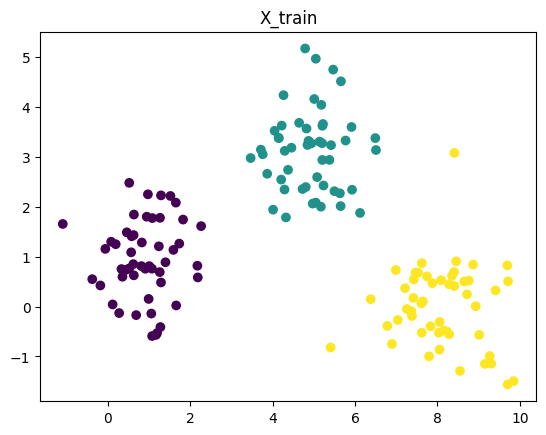

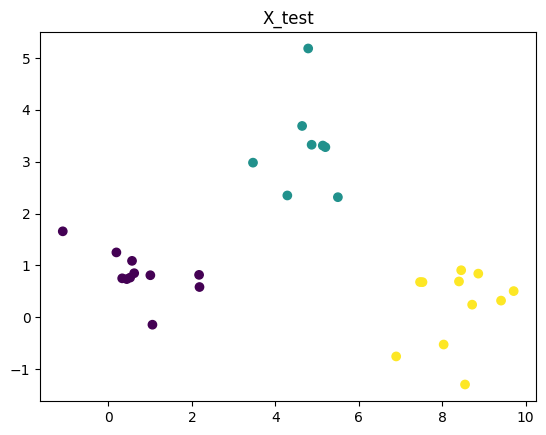

In [4]:
# Visualize the data
plt.scatter(
    X_np[:, 0], X_np[:, 1], c=np.argmax(y_np, axis=1), cmap=plt.cm.viridis
)
plt.title("X_train")
plt.show()

plt.scatter(
    X_test_np[:, 0],
    X_test_np[:, 1],
    c=np.argmax(y_test_np, axis=1),
    cmap=plt.cm.viridis,
)
plt.title("X_test")
plt.show()

In [5]:
# Define the MLP modules.


class Module:
    def forward(self, *args, **kwargs):
        raise NotImplementedError("Subclasses must implement this method")

    def parameters(self):
        raise NotImplementedError("Subclasses must implement this method")

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


class Linear(Module):
    def __init__(self, input_size, output_size):
        weight = (np.random.randn(input_size, output_size) * 0.01).astype(
            np.float32
        )
        bias = np.zeros((1, output_size)).astype(np.float32)
        self.weight = framework.Tensor.from_numpy(weight)
        self.bias = framework.Tensor.from_numpy(bias)

    def parameters(self):
        return [self.weight, self.bias]

    def forward(self, x):
        x = ops.matmul(x, self.weight)
        x = ops.add(x, self.bias)
        return x


# Define the MLP model
class SimpleMLP(Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.fc1 = Linear(input_size, hidden_size)
        self.fc2 = Linear(hidden_size, output_size)

    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

    def forward(self, x):
        x = self.fc1(x)
        x = ops.relu(x)
        x = self.fc2(x)
        x = ops.softmax(x)
        return x

In [6]:
# Define the loss function
def categorical_cross_entropy(y_true, y_pred):
    batch_size = y_true.shape[0]
    loss = ops.multiply(y_true, ops.log(y_pred))
    loss = ops.sum(loss)
    loss = ops.multiply(loss, -1.0 / batch_size)
    return loss

In [7]:
# Define the SGD optimizer
class SGD:
    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = None

    def step(self):
        for parameter in self.parameters:
            ops.add_(parameter, ops.multiply(parameter.grad, -self.lr))

In [8]:
# Instantiate the model
model = SimpleMLP(input_size, hidden_size, output_size)

# Define loss function and optimizer
optimizer = SGD(model.parameters(), lr=0.05)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = categorical_cross_entropy(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.numpy()[0]:.4f}")

Epoch [10/100], Loss: 10.1056
Epoch [20/100], Loss: 5.3407
Epoch [30/100], Loss: 3.8434
Epoch [40/100], Loss: 2.6528
Epoch [50/100], Loss: 5.8417
Epoch [60/100], Loss: 1.2443
Epoch [70/100], Loss: 0.8948
Epoch [80/100], Loss: 0.6933
Epoch [90/100], Loss: 0.5664
Epoch [100/100], Loss: 0.4817


In [9]:
# Evaluation
test_outputs = model(X_test).numpy()
y_pred = np.argmax(test_outputs, axis=1)
y_true = np.argmax(y_test_np, axis=1)
accuracy = (y_pred == y_true).sum() / y_true.shape[0]
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 1.0000


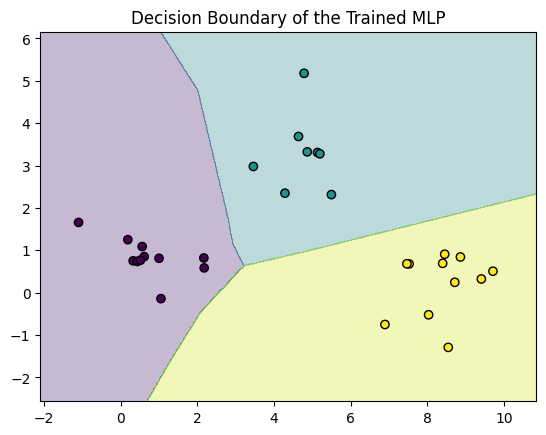

In [10]:
# Visualize the decision boundary (for 2D data)
h = 0.02
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
input = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
input_tensor = framework.Tensor.from_numpy(input)
Z = model(input_tensor).numpy()
Z_pred = np.argmax(Z, axis=1)
Z = Z_pred.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.3)
plt.scatter(
    X_test_np[:, 0],
    X_test_np[:, 1],
    c=np.argmax(y_test_np, axis=1),
    cmap=plt.cm.viridis,
    edgecolors="k",
)
plt.title("Decision Boundary of the Trained MLP")
plt.show()